In [20]:
from agglomerative_clustering_ml.agglomerative_clustering import agglomerative
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt

Data shape: (800, 2)
Custom linkage shape: (799, 4)
SciPy linkage shape:  (799, 4)
Exact (tolerant) equality of linkage matrices? -> True
Summary: {'nrows': 799, 'n_diffs': 0, 'diffs_head': []}

Last 4 rows of custom linkage (last merges):
[idx1, idx2, dist, new_cluster_size]
[[1590.         1589.           10.3625981   228.        ]
 [1593.         1594.           12.48526114  476.        ]
 [1595.         1587.           14.27841123  324.        ]
 [1597.         1596.           15.83413277  800.        ]]

Last 4 rows of SciPy linkage (last merges):
[idx1, idx2, dist, new_cluster_size]
[[1589.         1590.           10.3625981   228.        ]
 [1593.         1594.           12.48526114  476.        ]
 [1587.         1595.           14.27841123  324.        ]
 [1596.         1597.           15.83413277  800.        ]]


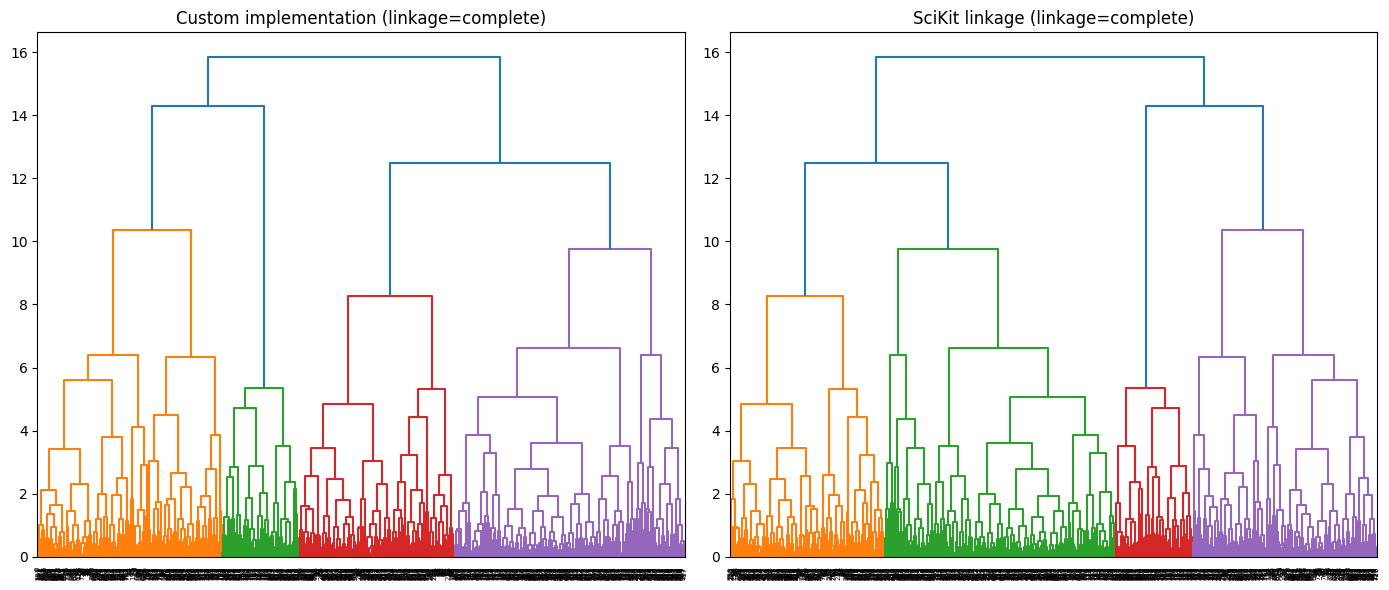


Cluster labels for 4 clusters (custom): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 1 3 1 3 3 1 1 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 4 4 2 1 2 2 1 2 2 2
 2 1 2 2 4 2 2 2 2 2 2 2 1 2 1 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3
 3 3 4 3 3 3 3 3 4 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 3 4 3 3 4 3 4 4 4 4 4 4 3 4 4 3 4 3
 3 3 3 3 4 4 4 4 4 4 4 3 4 4 3 4 3 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 3
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 3 3 3 3 4 4 3 3 4 3 3 3 4 3 3 4 3 3 3 4 3 3 

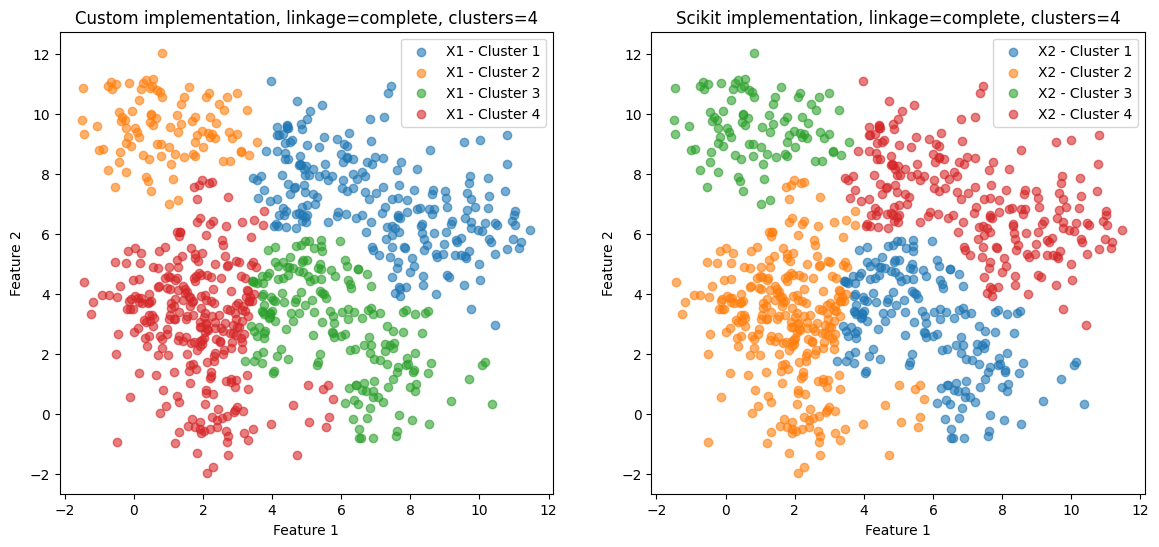

In [22]:
#!/usr/bin/env python3
"""
compare_dendrograms.py

Compare dendrograms produced by your NumPy-only agglomerative implementation
(with SciPy-style linkage output) to SciPy's linkage implementation.

Place this file in the same directory as your `agglomerative.py` from earlier
so we can `from agglomerative import agglomerative`.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

# Import your implementation; ensure file agglomerative.py is in same folder.
# It must export `agglomerative(X, n_clusters=..., linkage=..., return_linkage=True)`
from agglomerative_clustering_ml.agglomerative_clustering import agglomerative

# ---------------------------
# Utilities
# ---------------------------
def plot_two_dendrograms(Z_left, title_left, Z_right, title_right, labels=None, figsize=(14,6)):
    """
    Plot two dendrograms side-by-side for visual comparison.

    @param Z_left: linkage matrix (n-1,4) for left plot
    @param title_left: title string for left plot
    @param Z_right: linkage matrix (n-1,4) for right plot
    @param title_right: title string for right plot
    @param labels: optional list/array of sample labels for leaf nodes
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].set_title(title_left)
    dn0 = hierarchy.dendrogram(Z_left, labels=labels, ax=axes[0], leaf_rotation=90)
    axes[1].set_title(title_right)
    dn1 = hierarchy.dendrogram(Z_right, labels=labels, ax=axes[1], leaf_rotation=90)
    plt.tight_layout()
    plt.show()

def plot_scatter(X1, X2, X1_title=None, X2_title=None, labels1=None, labels2=None, figsize=(14,6)):
    """
    Simple scatter plot of 2D data points.

    @param X1: (n_samples, 2) array of x,y coordinates
    @param X2: (n_samples, 2) array of x,y coordinates
    @param labels: optional list/array of sample labels for coloring
    """
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    if labels1 is None:
        ax[0].scatter(X1[:,0], X1[:,1], c='blue', label='X1', alpha=0.6)
    else:
        unique_labels = np.unique(labels1)
        for ul in unique_labels:
            mask = (labels1 == ul)
            ax[0].scatter(X1[mask,0], X1[mask,1], label='X1 - Cluster {}'.format(ul), alpha=0.6)
    if labels2 is None:
        ax[1].scatter(X2[:,0], X2[:,1], c='red', label='X2', alpha=0.6)
    else:
        unique_labels = np.unique(labels2)
        for ul in unique_labels:
            mask = (labels2 == ul)
            ax[1].scatter(X2[mask,0], X2[mask,1], label='X2 - Cluster {}'.format(ul), alpha=0.6)
            
    if X1_title is not None:
        ax[0].set_title(X1_title)
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')
    ax[0].legend()
    
    if X2_title is not None:
        ax[1].set_title(X2_title)
    ax[1].set_xlabel('Feature 1')
    ax[1].set_ylabel('Feature 2')
    ax[1].legend()
    
    plt.show()


def compare_linkage_matrices(Z1, Z2, atol=1e-10):
    """
    Quick comparison: exact equality of node pairs is tricky (node ids for newly formed clusters
    depend on order), so we compare rows by (sorted pair ids, distance, size) but distances may
    differ slightly — we compare up to tolerance.

    Returns: list of indices where rows differ significantly, and a summary boolean.
    """
    if Z1.shape != Z2.shape:
        return False, {"reason": "shape_mismatch", "shape1": Z1.shape, "shape2": Z2.shape}

    nrows = Z1.shape[0]
    diffs = []
    for r in range(nrows):
        a1, b1, d1, s1 = Z1[r]
        a2, b2, d2, s2 = Z2[r]
        # compare cluster sizes exactly
        if int(s1) != int(s2):
            diffs.append((r, "size", int(s1), int(s2)))
            continue
        # distances compared within tolerance
        if not np.isclose(d1, d2, atol=atol, rtol=1e-12):
            diffs.append((r, "dist", float(d1), float(d2)))
            continue
        # node ids (a,b) are more brittle; we don't demand exact equal node ids here
    ok = len(diffs) == 0
    return ok, {"nrows": nrows, "n_diffs": len(diffs), "diffs_head": diffs[:10]}


# ---------------------------
# Experiment configurations
# ---------------------------
def make_toy_data(seed=0):
    rng = np.random.RandomState(seed)
    # Two blobs + a few noisy points to encourage merges/ties
    A = rng.normal(loc=0.0, scale=0.25, size=(8, 2))
    B = rng.normal(loc=2.0, scale=0.25, size=(7, 2))
    noise = rng.normal(loc=1.0, scale=0.9, size=(3, 2))
    X = np.vstack([A, B, noise])
    return X


def make_large_data(seed=0, blobs=5, points_per_blob=20, blob_spread=0.3, noise_points=0):
    rng = np.random.RandomState(seed)
    centers = rng.uniform(low=0.0, high=10.0, size=(blobs, 2))
    X_list = []
    for c in centers:
        X_blob = rng.normal(loc=c, scale=blob_spread, size=(points_per_blob, 2))
        X_list.append(X_blob)
    noise = rng.uniform(low=-1.0, high=11.0, size=(noise_points, 2))
    if noise_points > 0:
        X_list.append(noise)
    X = np.vstack(X_list)
    return X

def convert_to_scipy_linkage(model):
    """
    Convert sklearn AgglomerativeClustering to scipy linkage matrix format.
    Returns: linkage matrix with shape (n_samples-1, 4)
    Each row: [cluster1, cluster2, distance, sample_count]
    """
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    linkage_matrix = np.column_stack([
        model.children_,
        model.distances_,
        counts
    ]).astype(float)
    
    # Calculate the number of samples in each merged cluster
    for i, merge in enumerate(model.children_):
        count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                count += 1  # Original sample
            else:
                count += linkage_matrix[child_idx - n_samples, 3]
        linkage_matrix[i, 3] = count
    
    return linkage_matrix

# ---------------------------
# Main comparison routine
# ---------------------------
def main():
    # X = make_toy_data(seed=67)
    X = make_large_data(seed=67, blobs=15, points_per_blob=50, blob_spread=1, noise_points=50)
    n = X.shape[0]
    
    print("Data shape:", X.shape)
    if n < 20: print("Data points:\n", X)

    # Compute pairwise distances
    Y = pdist(X, metric="euclidean")   # condensed
    D_full = squareform(Y)             # (n,n) symmetric

    # === 1) Run your implementation (expects it to return SciPy-style linkage if return_linkage=True) ===
    # NOTE: our agglomerative function expects raw data X and computes distances internally.
    # We'll call it directly with same linkage as SciPy's.
    linkage_method = "complete"  # change to 'single', 'complete' to test others

    labels_custom, Z_custom = agglomerative(X, n_clusters=1, linkage=linkage_method, return_linkage=True)
    # Z_custom shape (n-1, 4) expected

    # Scikit-learn Agglomerative Clustering with distance_threshold=0
    clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=0,
        linkage=linkage_method,  # or 'complete', 'average', 'single'
        compute_distances=True
    )

    # Fit the model
    clustering.fit(X)

    # Get scipy-format linkage matrix
    Z_sci = convert_to_scipy_linkage(clustering)

    # === 2) Run SciPy's linkage on the same data (make sure SciPy uses same method) ===
    # For ward, SciPy expects 'ward' on raw observations (it uses Euclidean).
    # For centroid, use 'centroid'. For 'average' use 'average', etc.
    # Z_sci = hierarchy.linkage(Y, method=linkage_method)  # SciPy takes condensed distances

    # === 3) Compare linkage matrices and print diagnostics ===
    print("Custom linkage shape:", Z_custom.shape)
    print("SciPy linkage shape: ", Z_sci.shape)

    equal, summary = compare_linkage_matrices(Z_custom, Z_sci, atol=1e-10)
    print("Exact (tolerant) equality of linkage matrices? ->", equal)
    print("Summary:", summary)

    # Show last few merges of each linkage (most global merges are often less ambiguous)
    k = 4
    print("\nLast {} rows of custom linkage (last merges):".format(k))
    print("[idx1, idx2, dist, new_cluster_size]")
    print(Z_custom[-k:])
    print("\nLast {} rows of SciPy linkage (last merges):".format(k))
    print("[idx1, idx2, dist, new_cluster_size]")
    print(Z_sci[-k:])

    # === 4) Plot dendrograms side-by-side ===
    labels = [str(i) for i in range(n)]
    plot_two_dendrograms(Z_custom, "Custom implementation (linkage={})".format(linkage_method),
                         Z_sci, "SciKit linkage (linkage={})".format(linkage_method),
                         labels=labels)

    # === 5) Optional: Cluster label comparison at a chosen number of clusters ===
    from scipy.cluster.hierarchy import fcluster
    num_clusters_to_test = 4
    lab_custom = fcluster(Z_custom, t=num_clusters_to_test, criterion="maxclust")
    lab_scipy  = fcluster(Z_sci,  t=num_clusters_to_test, criterion="maxclust")
    print("\nCluster labels for {} clusters (custom):".format(num_clusters_to_test), lab_custom)
    print("Cluster labels for {} clusters (SciPy):".format(num_clusters_to_test), lab_scipy)
    
    plot_scatter(X, X,
                 X1_title=f"Custom implementation, linkage={linkage_method}, clusters={num_clusters_to_test}",
                 X2_title=f"Scikit implementation, linkage={linkage_method}, clusters={num_clusters_to_test}",
                 labels1=lab_custom, labels2=lab_scipy)

if __name__ == "__main__":
    main()
